In [23]:
import requests
import pandas as pd
import json
import networkx as nx

In [2]:
BASE_URL = "https://api.nb.no/ngram/db2"
BASE_URL1 = "https://api.nb.no/ngram/db1"

In [10]:
import dhlab_v2 as d2

In [3]:
def konk(urns=None, word=None, before=5, after=5, only_urn=True):
    params = locals()
    #print(params)
    r = requests.post("https://api.nb.no/ngram/urnkonk", json = params)
    return r.json()

def meta_natbib(children = False, yearfrom = "", yearto = "", lang = None, author = None, title = None, subtitle = None, publisher = None, subject = None, topic = None, marctuples = None, limit=20):
    params = locals()
    #print(params)
    r = requests.post("https://api.nb.no/ngram/get_urns", json = params)
    return r.json()

def metadata(urns=None, marctuples = [(100,1,' ', 'a'),(260, ' ',' ', 'c'), (245,1,3,'a'),(245,1,0,'a'),(245,1,3,'b'),(245,1,0,'b'), (650,7,' ','a'), (653,' ',' ','a')]):
    params = locals()
    #print(params)
    r = requests.post("https://api.nb.no/ngram/metadata", json=params)
    return r.json()

In [4]:
def frequencies(urns = None, cutoff = 0):
    params = locals()
    r = requests.post(BASE_URL1 + "/frequencies", json = params)
    result = r.json()
    structure = {u[0][0] : dict([tuple(x[1:]) for x in u]) for u in result if u != []}
    return structure

In [5]:
def find_urns(docids = None):
    params = locals()
    r = requests.post(BASE_URL1 + "/find_urn", json = params)
    return r.json()

In [6]:
def get_reference(corpus = 'digavis', from_year = 1950, to_year = 1955, lang = 'nob', limit = 100000):
    params = locals()
    r = requests.get(BASE_URL + "/reference_corpus", params = params)
    if r.status_code == 200:
        result = r.json()
    else:
        result = []
    return pd.DataFrame(result, columns = ['word', 'freq']).set_index('word')

In [11]:

def nb_ngram(terms, corpus='bok', smooth=3, years=(1810, 2010), mode='relative'):
    df = ngram_conv(get_ngram(terms, corpus=corpus), smooth=smooth, years=years, mode=mode)
    df.index = df.index.astype(int)
    return df

def get_ngram(terms, corpus='avis'):
    req = requests.get(
        "https://beta.nb.no/dhlab/ngram_1/ngram/query?", 
        params = { 
            'terms':terms,
            'corpus':corpus
        }
    )
    if req.status_code == 200:
        res = req.text
    else:
        res = "[]"
    return json.loads(res)

def ngram_conv(ngrams, smooth=1, years=(1810,2013), mode='relative'):
    ngc = {}
    # check if relative frequency or absolute frequency is in question
    if mode.startswith('rel') or mode=='y':
        arg = 'y'
    else:
        arg = 'f'
    for x in ngrams:
        if x != []:
            ngc[x['key']] = {z['x']:z[arg] for z in x['values'] if int(z['x']) <= years[1] and int(z['x']) >= years[0]}
    return pd.DataFrame(ngc).rolling(window=smooth, win_type='triang').mean()


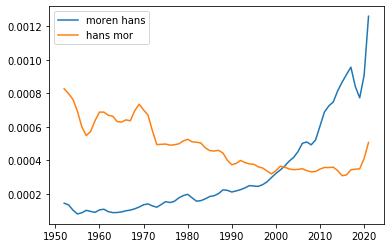

In [20]:
nb_ngram("moren hans, hans mor", years = (1950, 2022)).plot()

In [41]:
def make_word_graph(words, corpus ='all', cutoff=20, leaves=0):
    """Get galaxy from ngram-database. English and German provided by Google N-gram. 
    Set leaves=1 to get the leaves. Parameter cutoff only works for lang='nob'. 
    Specify English by setting lang='eng' and German by lang='ger'"""
    
    params = dict()
    params['terms'] = words
    params['corpus'] = corpus
    params['limit'] = cutoff
    params['leaves'] = leaves
    result = requests.get("https://beta.nb.no/dhlab/galaxies/query", params=params)
    G = nx.DiGraph()
    edgelist = []
    if result.status_code == 200:
        graph = json.loads(result.text)
        #print(graph)
        nodes = graph['nodes']
        edges = graph['links']
        for edge in edges:
            edgelist += [(nodes[edge['source']]['name'], nodes[edge['target']]['name'], abs(edge['value']))]
    #print(edgelist)
    G.add_weighted_edges_from(edgelist)

    return G

In [42]:
g = make_graph('demokrati', corpus = 'all')

In [34]:
https://beta.nb.no/dhlab/galaxies/query?terms=korona&leaves=0&limit=10&corpus=all



<Response [500]>

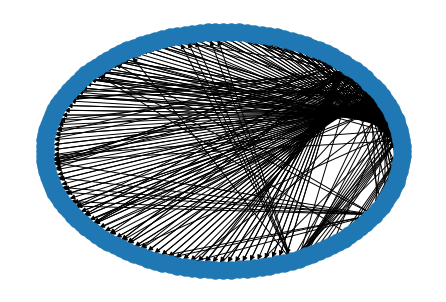

In [43]:
nx.draw_circular(g)

In [9]:
get_reference(limit = 100)

,freq
word,
.,179730338
",",105895990
i,63385398
og,58712477
til,30987239
...,...
s,2041889
5,2033613
m,2028738


In [10]:
urns = list(d2.document_corpus(from_year = 2000, to_year = 2002, limit = 10).urn)

In [11]:
result = frequencies(urns = urns, cutoff = 20)

In [12]:
import pandas as pd

In [15]:
df = pd.DataFrame(result)

In [24]:
fu = find_urns(docids = list(df.columns))

In [28]:
pd.DataFrame.from_dict(fu, orient = 'index', columns = ['urn'])

,urn
200135263,URN:NBN:no-nb_digavis_arbeidetsrett_null_null_...
200382347,URN:NBN:no-nb_digavis_dagsavisen_null_null_200...
200553644,URN:NBN:no-nb_digavis_fiskeribladet_null_null_...
200769595,URN:NBN:no-nb_digavis_harstadtidende_null_null...
201457838,URN:NBN:no-nb_digavis_romerikesblad_null_null_...
201568584,URN:NBN:no-nb_digavis_sognavis_null_null_20010...
201752010,URN:NBN:no-nb_digavis_tromsfolkeblad_null_null...
201824775,URN:NBN:no-nb_digavis_ullensakerblad_null_null...
202574785,URN:NBN:no-nb_digavis_nordhordland_null_null_2...
300065604,URN:NBN:no-nb_digitidsskrift_2021011981065_001


In [79]:
import dhlab.nbtext as nb

In [93]:
t = nb.book_corpus(author='ibsen%', title='%dukke%', period=(1800, 2010))

In [95]:
list(t.urn)

[2011010609040,
 2010031510001,
 2010112608074,
 2016031009565,
 2009061000024,
 2010082422025,
 2011072908024,
 2010083123001,
 2015120808042,
 2012091409046,
 2012082309582,
 2007082204013,
 2013010808064,
 2007091301037,
 2008112000060,
 2011040608127,
 2012080709541,
 2011082409020,
 2011030820014,
 2010083022002]

In [111]:
metadata(urns = list([str(x) for x in t.urn]), marctuples = [(100,1,' ', 'a'), (245,1,3,'a')])

{'2007082204013': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem :',
  'lang': 'nob',
  'year': 1991},
 '2007091301037': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem',
  'lang': 'nob',
  'year': 1989},
 '2008112000060': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem',
  'lang': 'nob',
  'year': 2001},
 '2009061000024': [],
 '2010031510001': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem :',
  'lang': 'nob',
  'year': 1879},
 '2010082422025': [],
 '2010083022002': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem og fire andre skuespil',
  'lang': 'nob',
  'year': 2006},
 '2010083123001': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem ; Gengangere ; Vildanden',
  'lang': 'nob',
  'year': 1989},
 '2010112608074': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem',
  'lang': 'nob',
  'year': 1995},
 '2011010609040': {'100-1- -a': 'Ibsen, Henrik',
  '245-1-3-a': 'Et dukkehjem :',
  'lang': 'nob',
  'year